In [1]:
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import jsonlines
import altair as alt
from vega_datasets import data

In [2]:
def fix_value_format(value):
        
    if str(value) == "True" or str(value) == "False":
        is_bool = True
        value_str = value
    else:
        is_bool = False

    if not is_bool:
        value_str = f"{value:.10f}"
        # remove 0s at the end of the string except if it's just after the dot or before the dot
        value_str = value_str.rstrip("0") if "." in value_str else value_str
        if value_str.endswith("."):
            value_str = value_str + "0"
    return value_str

def load_detection_results_data(parameter_name, parameter_value_list, gen_name, exp_prefix_name):
    dfs_list = []

    for _, value in enumerate(parameter_value_list):
        value_str = fix_value_format(value)
        file_path = f"../paper_results/detection_test_results/watermark_detector_SWEET_P/cnn_dailymail/no_attack/{gen_name}/test/{exp_prefix_name}_{value_str}.json"
        with open(file_path, "r") as file:
            json_data = json.load(file)
            df = pd.json_normalize(json_data)
        df[parameter_name] = value
        dfs_list.append(df)

    # combine the dfs using the concat function
    detect_df = pd.concat(dfs_list)
    return detect_df

def load_text_quality_results_data(parameter_name, parameter_value_list, gen_name, exp_prefix_name):
    dfs_list = []
    for _, value in enumerate(parameter_value_list):
        value_str = fix_value_format(value)
        
        file_path = f"../paper_results/text_quality_eval_results/SWEET_P_vs_/cnn_dailymail/no_attack/{gen_name}/quality_test_{exp_prefix_name}_{value_str}_vs_.json"
        with open(file_path, "r") as file:
            json_data = json.load(file)
            df = pd.json_normalize(json_data)
        df[parameter_name] = value
        dfs_list.append(df)

    # combine the dfs using the concat function
    quality_df = pd.concat(dfs_list)

    quality_df["ppl_score.score"] = quality_df["ppl_score.score"].astype(float)
    quality_df["ppl_score.lower_bound"] = quality_df["ppl_score.lower_bound"].astype(float)
    quality_df["ppl_score.upper_bound"] = quality_df["ppl_score.upper_bound"].astype(float)
    
    return quality_df

def get_combined_plot(detect_df, quality_df, ablation_parameter_name, ppl_baseline, legend_name,
                     x_lim_min=0, x_lim_max=0, y_lim_min=0, y_lim_max=0, ax=None, save_path=None,
                     no_legend=False, marker_type="o", x_axis_target_text_loc=None, y_axis_target_text_loc=None):
    
    tpr_target = 0.95
    ppl_target = ppl_baseline + ppl_baseline * 0.05

    combined_df = pd.merge(detect_df, quality_df, on=ablation_parameter_name)

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # order by ablation_parameter_value
    combined_df_sorted = combined_df.sort_values(by=ablation_parameter_name).reset_index(drop=True)
  
    # Plot the black dashed line without markers
    sns.lineplot(data=combined_df_sorted, x="ppl_score.score", y="tp_rate_at_given_threshold",
                color="black", linestyle="--", marker=None, ax=ax, sort=False)
    
    # Add target lines
    ax.axvline(x=ppl_target, color="r", linestyle="-")
    ax.axhline(y=tpr_target, color="b", linestyle="-")

    # magma, rocket
    palette = sns.color_palette("viridis", 6)

    # Plot main line with markers
    sns.lineplot(data=combined_df, x="ppl_score.score", y="tp_rate_at_given_threshold",
                marker=marker_type, linestyle="", markersize=8, hue=ablation_parameter_name,
                palette=palette, ax=ax)

    # Add hollow circles around points above targets
    above_target_df = combined_df[
        (combined_df["ppl_score.score"] <= ppl_target) & 
        (combined_df["tp_rate_at_given_threshold"] >= tpr_target)
    ]
    if not above_target_df.empty:
        sns.scatterplot(data=above_target_df, x="ppl_score.score", y="tp_rate_at_given_threshold",
                       marker="o", facecolors='none', edgecolors='gold', s=300, 
                       linewidth=2, ax=ax, zorder=10, legend=False)
        
    # Add text explanations with automatic positioning
    # Vertical text for PPL target (right side due to reversed x-axis)

    if x_axis_target_text_loc and y_axis_target_text_loc:
        ax.text(x_axis_target_text_loc[0], x_axis_target_text_loc[1],
                f'PPL Target <=\n{ppl_target:.2f}', 
                verticalalignment='center',
                horizontalalignment='center',
                color='red',
                fontsize=8)
        
        # Horizontal text for TPR target
        ax.text(y_axis_target_text_loc[0], y_axis_target_text_loc[1],
                f'TPR Target >= {tpr_target}',
                horizontalalignment='right',
                verticalalignment='bottom',
                color='blue',
                fontsize=8)


    if y_lim_min != 0 and y_lim_max != 0:
        ax.set_ylim(y_lim_min, y_lim_max)

    if x_lim_min != 0 and x_lim_max != 0:
        ax.set_xlim(x_lim_min, x_lim_max)

    # Add legend and labels
    ax.legend(title=legend_name)
    ax.set_xlabel("PPL Score (→ better)")
    ax.set_ylabel("TPR@FPR=0.05 (→ better)")
    #ax.set_title("PPL score vs TPR@FPR=0.05 for SWEET-P watermark detection")

    # reverse the x-axis order
    ax.invert_xaxis()

    if no_legend:
        ax.get_legend().remove()
    
    if save_path is not None:
        # add 
        plt.savefig(save_path, bbox_inches='tight')

    return ax

In [3]:
target_fpr = 0.05
ppl_baseline = 6.6
ppl_target = ppl_baseline + ppl_baseline * 0.05
target_tpr = 0.95

# Bias strength

In [4]:
bias_values = [0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
gen_name = "llama_instruct_3.1"

bias_detect_df = load_detection_results_data("bias_value", bias_values, gen_name, "bias_variation_bias")
display(bias_detect_df.head(10))

bias_quality_df = load_text_quality_results_data("bias_value", bias_values, gen_name, "bias_variation_bias")
display(bias_quality_df.head(10))

,accuracy,precision,recall,f1_score,fp_rate,tp_rate,std_accuracy,std_precision,std_recall,std_f1_score,...,watermarking_config.delta,watermarking_config.hash_key,watermarking_config.prefix_length,watermarking_config.z_threshold,watermarking_config.entropy_threshold,watermarking_config.cut_off_method,watermarking_config.prob_ratio,watermarking_config.top_p,watermarking_config.use_surrogate_model,bias_value
0,0.501450,0.866,0.004146,0.008240,0.0,0.004146,0.016042,0.340652,0.002925,0.005789,...,0.5,15485863,1,4.0,1.0,ratio,0.25,0.8,True,0.5
0,0.508628,1.000,0.018320,0.035915,0.0,0.018320,0.016146,0.000000,0.005933,0.011429,...,1.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,1.0
0,0.586572,1.000,0.172197,0.293422,0.0,0.172197,0.015788,0.000000,0.017517,0.025477,...,2.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,2.0
0,0.680534,1.000,0.360581,0.529680,0.0,0.360581,0.014641,0.000000,0.021282,0.022955,...,5.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,5.0
0,0.674536,1.000,0.347220,0.515092,0.0,0.347220,0.015163,0.000000,0.021265,0.023406,...,10.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,10.0
0,0.674704,1.000,0.350252,0.518426,0.0,0.350252,0.014695,0.000000,0.021343,0.023387,...,20.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,20.0


,ppl_score.score,ppl_score.lower_bound,ppl_score.upper_bound,ppl_score.loss_lists,config.dataset_name,config.data_experiment_name_main,config.data_experiment_name_compare,config.generator_name,config.batch_size,config.use_bert_scorer,...,config.use_prometheus_scorer,config.use_ppl_scorer,config.return_loss_lists,config.ppl_scorer_name,config.compare_ai_to_human,config.eval_human,config.watermarking_scheme_name_main,config.watermarking_scheme_name_compare,config.save_res_dir,bias_value
0,6.381460,6.270685,6.492136,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,bias_variation_bias_0.5,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.5
0,6.192919,6.084022,6.302839,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,bias_variation_bias_1.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,1.0
0,6.089143,5.984017,6.200304,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,bias_variation_bias_2.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,2.0
0,6.244163,6.132956,6.358956,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,bias_variation_bias_5.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,5.0
0,6.253898,6.138588,6.368408,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,bias_variation_bias_10.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,10.0
0,6.294197,6.179773,6.414676,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,bias_variation_bias_20.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,20.0


## Combine detection and text quality

<Axes: xlabel='PPL Score (→ better)', ylabel='TPR@FPR=0.05 (→ better)'>

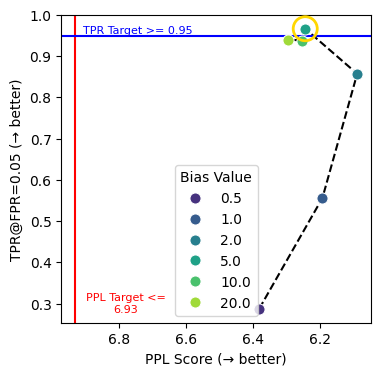

In [5]:
ablation_parameter_name = "bias_value"
legend_name = "Bias Value"
detect_df = bias_detect_df
quality_df = bias_quality_df
save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_bias.png"
x_axis_target_text_loc = (ppl_target - 0.15, 0.3)
y_axis_target_text_loc = (ppl_target - 0.35, 0.95)


get_combined_plot(detect_df, quality_df, ablation_parameter_name, ppl_baseline, legend_name,
                  save_path=save_path, x_axis_target_text_loc=x_axis_target_text_loc, y_axis_target_text_loc=y_axis_target_text_loc)


# Cut-off method

## Prob ratio

In [6]:
prob_ratio_values: list[float] = [0.00001, 0.05, 0.1, 0.25, 0.35, 0.5]
gen_name = "llama_instruct_3.1"
exp_prefix_name = "prob_ratio_variation"

prob_ratio_detect_df = load_detection_results_data("prob_ratio", prob_ratio_values, gen_name, exp_prefix_name)
display(prob_ratio_detect_df.head())

prob_ratio_quality_df = load_text_quality_results_data("prob_ratio", prob_ratio_values, gen_name, exp_prefix_name)
display(prob_ratio_quality_df.head())


,accuracy,precision,recall,f1_score,fp_rate,tp_rate,std_accuracy,std_precision,std_recall,std_f1_score,...,watermarking_config.delta,watermarking_config.hash_key,watermarking_config.prefix_length,watermarking_config.z_threshold,watermarking_config.entropy_threshold,watermarking_config.cut_off_method,watermarking_config.prob_ratio,watermarking_config.top_p,watermarking_config.use_surrogate_model,prob_ratio
0,0.968608,1.0,0.937325,0.967617,0.0,0.937325,0.005494,0.0,0.010745,0.005733,...,5.0,15485863,1,4.0,1.0,ratio,0.00001,0.8,True,0.00001
0,0.935939,1.0,0.871932,0.931511,0.0,0.871932,0.007909,0.0,0.015555,0.008891,...,5.0,15485863,1,4.0,1.0,ratio,0.05000,0.8,True,0.05000
0,0.881086,1.0,0.762114,0.864872,0.0,0.762114,0.010097,0.0,0.018633,0.011997,...,5.0,15485863,1,4.0,1.0,ratio,0.10000,0.8,True,0.10000
0,0.664345,1.0,0.327748,0.493284,0.0,0.327748,0.015276,0.0,0.021776,0.024723,...,5.0,15485863,1,4.0,1.0,ratio,0.25000,0.8,True,0.25000
0,0.590963,1.0,0.183879,0.310261,0.0,0.183879,0.015722,0.0,0.017680,0.025233,...,5.0,15485863,1,4.0,1.0,ratio,0.35000,0.8,True,0.35000


,ppl_score.score,ppl_score.lower_bound,ppl_score.upper_bound,ppl_score.loss_lists,config.dataset_name,config.data_experiment_name_main,config.data_experiment_name_compare,config.generator_name,config.batch_size,config.use_bert_scorer,...,config.use_prometheus_scorer,config.use_ppl_scorer,config.return_loss_lists,config.ppl_scorer_name,config.compare_ai_to_human,config.eval_human,config.watermarking_scheme_name_main,config.watermarking_scheme_name_compare,config.save_res_dir,prob_ratio
0,9.260526,9.043152,9.498682,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,prob_ratio_variation_0.00001,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.00001
0,7.571380,7.404398,7.719463,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,prob_ratio_variation_0.05,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.05000
0,6.986098,6.850454,7.116012,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,prob_ratio_variation_0.1,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.10000
0,6.228766,6.112343,6.359380,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,prob_ratio_variation_0.25,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.25000
0,5.928144,5.832461,6.036486,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,prob_ratio_variation_0.35,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.35000


<Axes: xlabel='PPL Score (→ better)', ylabel='TPR@FPR=0.05 (→ better)'>

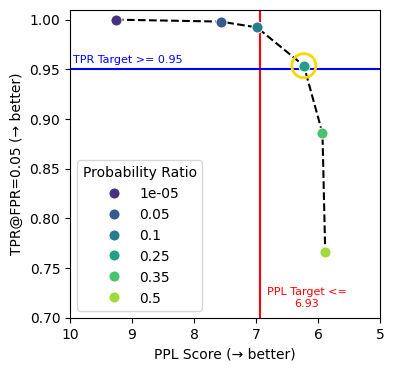

In [7]:
ablation_parameter_name = "prob_ratio"
legend_name = "Probability Ratio"
detect_df = prob_ratio_detect_df
quality_df = prob_ratio_quality_df

x_lim_min = 5
x_lim_max = 10
y_lim_min = 0.7
y_lim_max = 1.01

x_axis_target_text_loc = (ppl_target - 0.75, 0.72)
y_axis_target_text_loc = (ppl_target + 1.25, 0.955)


save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_prob_ratio.png"
get_combined_plot(detect_df, quality_df, ablation_parameter_name, ppl_baseline, legend_name,
                    x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max,
                    save_path=save_path, x_axis_target_text_loc=x_axis_target_text_loc, y_axis_target_text_loc=y_axis_target_text_loc)

## Watermark Top-p cut-off

In [8]:
top_values = [0.6, 0.8, 0.9, 0.95]
gen_name = "llama_instruct_3.1"
exp_prefix_name = "top_p_variation"

top_p_detect_df = load_detection_results_data("top_p_value", top_values, gen_name, exp_prefix_name)
display(top_p_detect_df.head())

top_p_quality_df = load_text_quality_results_data("top_p_value", top_values, gen_name, exp_prefix_name)
display(top_p_quality_df.head())

,accuracy,precision,recall,f1_score,fp_rate,tp_rate,std_accuracy,std_precision,std_recall,std_f1_score,...,watermarking_config.delta,watermarking_config.hash_key,watermarking_config.prefix_length,watermarking_config.z_threshold,watermarking_config.entropy_threshold,watermarking_config.cut_off_method,watermarking_config.prob_ratio,watermarking_config.top_p,watermarking_config.use_surrogate_model,top_p_value
0,0.557297,1.0,0.116042,0.207680,0.0,0.116042,0.015550,0.0,0.013783,0.022121,...,5.0,15485863,1,4.0,1.0,top_p,0.25,0.60,True,0.60
0,0.748304,1.0,0.496534,0.663263,0.0,0.496534,0.014471,0.0,0.022987,0.020557,...,5.0,15485863,1,4.0,1.0,top_p,0.25,0.80,True,0.80
0,0.916643,1.0,0.833606,0.909163,0.0,0.833606,0.008654,0.0,0.016633,0.009900,...,5.0,15485863,1,4.0,1.0,top_p,0.25,0.90,True,0.90
0,0.952316,1.0,0.904494,0.949800,0.0,0.904494,0.006978,0.0,0.013445,0.007417,...,5.0,15485863,1,4.0,1.0,top_p,0.25,0.95,True,0.95


,ppl_score.score,ppl_score.lower_bound,ppl_score.upper_bound,ppl_score.loss_lists,config.dataset_name,config.data_experiment_name_main,config.data_experiment_name_compare,config.generator_name,config.batch_size,config.use_bert_scorer,...,config.use_prometheus_scorer,config.use_ppl_scorer,config.return_loss_lists,config.ppl_scorer_name,config.compare_ai_to_human,config.eval_human,config.watermarking_scheme_name_main,config.watermarking_scheme_name_compare,config.save_res_dir,top_p_value
0,6.212656,6.098188,6.331884,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,top_p_variation_0.6,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.60
0,6.874148,6.736794,7.015500,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,top_p_variation_0.8,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.80
0,7.946677,7.777192,8.122613,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,top_p_variation_0.9,,llama_instruct_3.1,32,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.90
0,8.594710,8.388377,8.814336,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,top_p_variation_0.95,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.95


/tmp/ipykernel_22100/1638482909.py:81: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(data=combined_df, x="ppl_score.score", y="tp_rate_at_given_threshold",


<Axes: xlabel='PPL Score (→ better)', ylabel='TPR@FPR=0.05 (→ better)'>

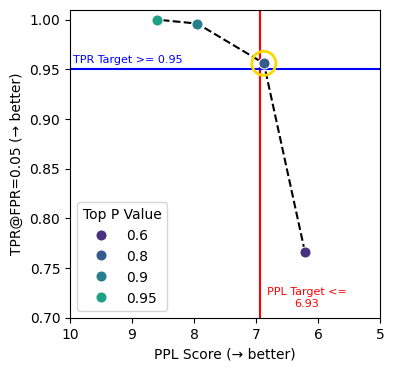

In [9]:
ablation_parameter_name = "top_p_value"
legend_name = "Top P Value"
detect_df = top_p_detect_df
quality_df = top_p_quality_df

x_lim_min = 5
x_lim_max = 10
y_lim_min = 0.7
y_lim_max = 1.01

x_axis_target_text_loc = (ppl_target - 0.75, 0.72)
y_axis_target_text_loc = (ppl_target + 1.25, 0.955)

save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_top_p.png"
get_combined_plot(detect_df, quality_df, ablation_parameter_name, ppl_baseline, legend_name,
                    x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max,
                    save_path=save_path, x_axis_target_text_loc=x_axis_target_text_loc, y_axis_target_text_loc=y_axis_target_text_loc)


/tmp/ipykernel_22100/1638482909.py:81: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(data=combined_df, x="ppl_score.score", y="tp_rate_at_given_threshold",


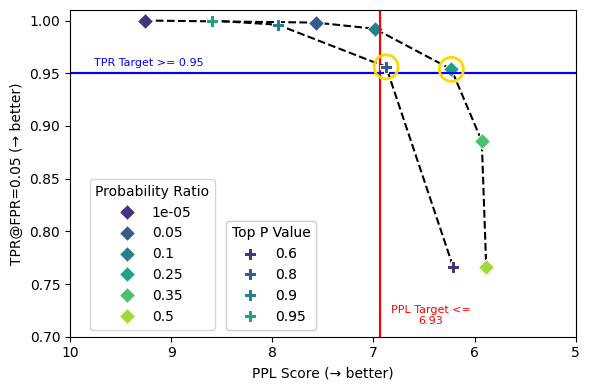

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

# First plot
ablation_parameter_name1 = "prob_ratio"
legend_name1 = "Probability Ratio"
detect_df1 = prob_ratio_detect_df
quality_df1 = prob_ratio_quality_df
ax1 = get_combined_plot(detect_df1, quality_df1, ablation_parameter_name1, ppl_baseline, legend_name1,
                 x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max, ax=ax,
                 no_legend=True, marker_type="D")

# Capture handles and labels after the first plot
handles1, labels1 = ax1.get_legend_handles_labels()

# Second plot
ablation_parameter_name2 = "top_p_value"
legend_name2 = "Top P Value"
detect_df2 = top_p_detect_df
quality_df2 = top_p_quality_df

x_axis_target_text_loc = (ppl_target - 0.5, 0.72)
y_axis_target_text_loc = (ppl_target + 1.75, 0.955)

ax2 = get_combined_plot(detect_df2, quality_df2, ablation_parameter_name2, ppl_baseline, legend_name2,
                 x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max, ax=ax,
                 no_legend=True, marker_type="P", x_axis_target_text_loc=x_axis_target_text_loc, y_axis_target_text_loc=y_axis_target_text_loc)

# Capture handles and labels for the second plot only
handles2, labels2 = ax.get_legend_handles_labels()

# Remove handles and labels already used by the first plot
handles2 = handles2[len(handles1):]
labels2 = labels2[len(labels1):]

# Add separate legends
legend1 = ax.legend(handles1, labels1, loc="lower right", title=legend_name1,
                    bbox_to_anchor=(0.3, 0.0))
legend2 = ax.legend(handles2, labels2, loc="lower right", title=legend_name2,
                    bbox_to_anchor=(0.5, 0.0))

# Manually add both legends back to the axes
ax.add_artist(legend1)
ax.add_artist(legend2)

save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_prob_ratio_vs_top_p_overlay.png"
plt.savefig(save_path, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [11]:
# 10 random numbers between 1 and 999
random_values = np.random.uniform(1, 999, 10)
random_values = [int(value) for value in random_values]
random_values

[112, 608, 959, 887, 44, 824, 908, 654, 268, 174]

/tmp/ipykernel_22100/1638482909.py:81: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(data=combined_df, x="ppl_score.score", y="tp_rate_at_given_threshold",


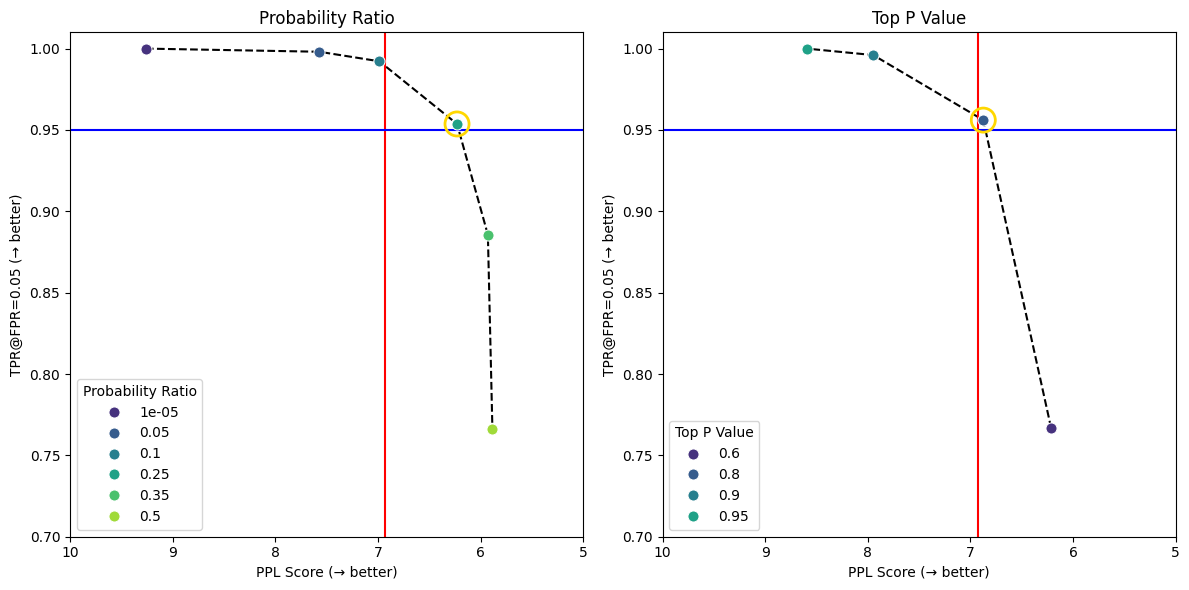

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
ablation_parameter_name1 = "prob_ratio"
legend_name1 = "Probability Ratio"
detect_df1 = prob_ratio_detect_df
quality_df1 = prob_ratio_quality_df
ax1 = get_combined_plot(detect_df1, quality_df1, ablation_parameter_name1, ppl_baseline, legend_name1,
                 x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max, ax=axes[0],
                 no_legend=False)

# Second plot
ablation_parameter_name2 = "top_p_value"
legend_name2 = "Top P Value"
detect_df2 = top_p_detect_df
quality_df2 = top_p_quality_df
ax2 = get_combined_plot(detect_df2, quality_df2, ablation_parameter_name2, ppl_baseline, legend_name2,
                 x_lim_min=x_lim_min, x_lim_max=x_lim_max, y_lim_min=y_lim_min, y_lim_max=y_lim_max, ax=axes[1],
                 no_legend=False)

# Titles and legends for each subplot
axes[0].set_title(legend_name1)
axes[1].set_title(legend_name2)

save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_prob_ratio_vs_top_p_subplots.png"
plt.savefig(save_path, bbox_inches="tight")
plt.tight_layout()
plt.show()


# Entropy threshold

In [13]:
entropy_thresholds=[0.0, 0.5, 1.0, 1.5, 2.0]
gen_name = "llama_instruct_3.1"
exp_prefix_name = "entropy_threshold_variation"

entropy_detect_df = load_detection_results_data("entropy_threshold", entropy_thresholds, gen_name, exp_prefix_name)
display(entropy_detect_df.head())

entropy_threshold_quality_df = load_text_quality_results_data("entropy_threshold", entropy_thresholds, gen_name, exp_prefix_name)
display(entropy_threshold_quality_df.head())

,accuracy,precision,recall,f1_score,fp_rate,tp_rate,std_accuracy,std_precision,std_recall,std_f1_score,...,watermarking_config.delta,watermarking_config.hash_key,watermarking_config.prefix_length,watermarking_config.z_threshold,watermarking_config.entropy_threshold,watermarking_config.cut_off_method,watermarking_config.prob_ratio,watermarking_config.top_p,watermarking_config.use_surrogate_model,entropy_threshold
0,0.661990,1.0,0.323348,0.488325,0.0,0.323348,0.014333,0.0,0.020332,0.023239,...,5.0,15485863,1,4.0,0.0,ratio,0.25,0.8,True,0.0
0,0.707023,1.0,0.414356,0.585579,0.0,0.414356,0.014492,0.0,0.022233,0.022263,...,5.0,15485863,1,4.0,0.5,ratio,0.25,0.8,True,0.5
0,0.683601,1.0,0.368387,0.538079,0.0,0.368387,0.014883,0.0,0.021038,0.022499,...,5.0,15485863,1,4.0,1.0,ratio,0.25,0.8,True,1.0
0,0.599682,1.0,0.200443,0.333569,0.0,0.200443,0.015392,0.0,0.018133,0.025144,...,5.0,15485863,1,4.0,1.5,ratio,0.25,0.8,True,1.5
0,0.538466,1.0,0.078203,0.144822,0.0,0.078203,0.016203,0.0,0.012261,0.021083,...,5.0,15485863,1,4.0,2.0,ratio,0.25,0.8,True,2.0


,ppl_score.score,ppl_score.lower_bound,ppl_score.upper_bound,ppl_score.loss_lists,config.dataset_name,config.data_experiment_name_main,config.data_experiment_name_compare,config.generator_name,config.batch_size,config.use_bert_scorer,...,config.use_prometheus_scorer,config.use_ppl_scorer,config.return_loss_lists,config.ppl_scorer_name,config.compare_ai_to_human,config.eval_human,config.watermarking_scheme_name_main,config.watermarking_scheme_name_compare,config.save_res_dir,entropy_threshold
0,6.196644,6.088857,6.307791,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,entropy_threshold_variation_0.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.0
0,6.227301,6.113094,6.340294,"[[3.948777198791504, 1.9709124565124512, 7.622...",cnn_dailymail,entropy_threshold_variation_0.5,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,0.5
0,6.286801,6.177284,6.401382,"[[5.338445663452148, 7.263540267944336, 12.154...",cnn_dailymail,entropy_threshold_variation_1.0,,llama_instruct_3.1,8,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,1.0
0,6.296582,6.186132,6.416717,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,entropy_threshold_variation_1.5,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,1.5
0,6.354522,6.244105,6.474586,"[[5.301959037780762, 7.3172502517700195, 12.08...",cnn_dailymail,entropy_threshold_variation_2.0,,llama_instruct_3.1,64,False,...,False,True,True,qwen2_chat_7B,False,False,SWEET_P,,text_quality_eval_results,2.0


/tmp/ipykernel_22100/1638482909.py:81: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(data=combined_df, x="ppl_score.score", y="tp_rate_at_given_threshold",


<Axes: xlabel='PPL Score (→ better)', ylabel='TPR@FPR=0.05 (→ better)'>

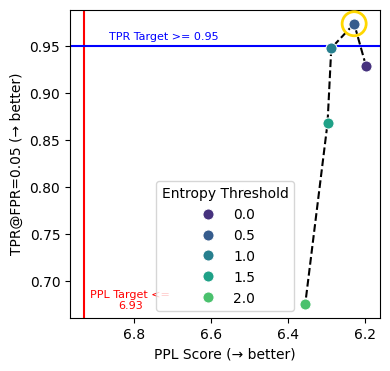

In [14]:
ablation_parameter_name = "entropy_threshold"
legend_name = "Entropy Threshold"
detect_df = entropy_detect_df
quality_df = entropy_threshold_quality_df

x_axis_target_text_loc = (ppl_target - 0.12, 0.68)
y_axis_target_text_loc = (ppl_target - 0.35, 0.955)

save_path = f"../paper_results/plots/ablation_study/ablation_study_watermark_entropy_threshold.png"
get_combined_plot(detect_df, quality_df, ablation_parameter_name, ppl_baseline, legend_name,
                    save_path=save_path, x_axis_target_text_loc=x_axis_target_text_loc, y_axis_target_text_loc=y_axis_target_text_loc)